In [1]:
pip install pandas numpy scikit-learn tensorflow matplotlib deap

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencensus 0.11.4 requires six~=1.16, but you have six 1.15.0 which is incompatible.
gsutil 5.31 requires google-auth[aiohttp]==2.17.0, but you have google-auth 1.35.0 which is incompatible.
gsutil 5.31 requires six>=1.16.0, but you have six 1.15.0 which is incompatible.
gcs-oauth2-boto-plugin 3.2 requires google-auth==2.17.0, but you have google-auth 1.35.0 which is incompatible.
flwr 0.18.0 requires dataclasses==0.6; python_version < "3.7", but you have dataclasses 0.8 which is incompatible.
flwr 0.18.0 requires importlib-metadata<2.0.0,>=1.4.0; python_version < "3.8", but you have importlib-metadata 4.8.3 which is incompatible.



  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached google_auth-1.35.0-py2.py3-none-any.whl (152 kB)
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.17.0
    Uninstalling google-auth-2.17.0:
      Successfully uninstalled google-auth-2.17.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from deap import base, creator, tools, algorithms


In [3]:
# Load datasets
datasets = ['CM1.csv', 'JM1.csv', 'MC1.csv', 'KC1.csv', 'PC1.csv']
dataframes = []

for dataset in datasets:
    df = pd.read_csv(f'data/{dataset}')
    dataframes.append(df)

# Check the structure of the datasets
for df in dataframes:
    print(df.head())


   LOC_BLANK  BRANCH_COUNT  CALL_PAIRS  LOC_CODE_AND_COMMENT  LOC_COMMENTS  \
0   0.054878      0.012579    0.115385                0.0250      0.005900   
1   0.115854      0.000000    0.038462                0.0250      0.000000   
2   0.000000      0.037736    0.000000                0.0000      0.000000   
3   0.012195      0.075472    0.076923                0.0125      0.026549   
4   0.030488      0.012579    0.038462                0.0000      0.000000   

   CONDITION_COUNT  CYCLOMATIC_COMPLEXITY  CYCLOMATIC_DENSITY  DECISION_COUNT  \
0         0.016393               0.010638            0.230769        0.017241   
1         0.000000               0.000000            0.038462        0.000000   
2         0.024590               0.031915            1.000000        0.000000   
3         0.081967               0.063830            0.288462        0.068966   
4         0.016393               0.010638            0.211538        0.017241   

   DECISION_DENSITY  ...  NODE_COUNT  NORMAL

In [5]:
def feature_engineering(df):
    # Example feature engineering function
    # You can implement specific feature selection logic here
    # For demonstration purposes, we'll use all features
    X = df.drop(columns=['Defective'])
    y = df['Defective']
    
    # You can implement a genetic algorithm here to select features
    # Placeholder for feature selection
    selected_features = X.columns.tolist()  # All features selected
    
    return X[selected_features], y

# Process each dataset
processed_data = []
for df in dataframes:
    X, y = feature_engineering(df)
    processed_data.append((X, y))


In [6]:
# Determine the maximum number of features across all datasets
max_features = max([X.shape[1] for X, y in processed_data])

# Create an empty list for padded data
padded_data = []

for X, y in processed_data:
    # Padding with zeros
    X_padded = np.zeros((X.shape[0], max_features))
    X_padded[:, :X.shape[1]] = X.values  # Fill in the features from the dataset
    padded_data.append((X_padded, y))

# Now `padded_data` contains all datasets with zero padding


In [7]:
def create_model(input_shape):
    model = keras.Sequential()
    model.add(layers.LSTM(50, input_shape=input_shape))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the model on each client
models = []
for X, y in padded_data:
    model = create_model((X.shape[1], 1))
    model.fit(X.reshape(X.shape[0], X.shape[1], 1), y, epochs=10, batch_size=32, verbose=0)
    models.append(model)


In [8]:
# Evaluate the models
for index, (X, y) in enumerate(padded_data):
    y_pred = (models[index].predict(X.reshape(X.shape[0], X.shape[1], 1)) > 0.5).astype("int32")
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f"Dataset {datasets[index]} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


Dataset CM1.csv - Accuracy: 0.63, Precision: 0.63, Recall: 0.62, F1 Score: 0.63
Dataset JM1.csv - Accuracy: 0.60, Precision: 0.74, Recall: 0.31, F1 Score: 0.44
Dataset MC1.csv - Accuracy: 0.76, Precision: 0.73, Recall: 0.83, F1 Score: 0.78
Dataset KC1.csv - Accuracy: 0.61, Precision: 0.65, Recall: 0.47, F1 Score: 0.54
Dataset PC1.csv - Accuracy: 0.73, Precision: 0.75, Recall: 0.70, F1 Score: 0.72


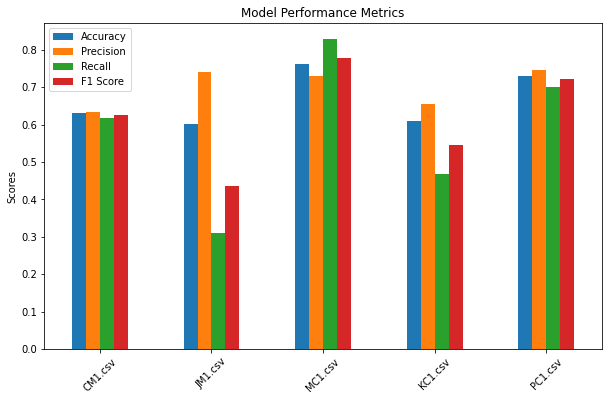

In [9]:
# Visualization of results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
results = []

for index, (X, y) in enumerate(padded_data):
    y_pred = (models[index].predict(X.reshape(X.shape[0], X.shape[1], 1)) > 0.5).astype("int32")
    
    results.append([
        accuracy_score(y, y_pred),
        precision_score(y, y_pred),
        recall_score(y, y_pred),
        f1_score(y, y_pred)
    ])

results_df = pd.DataFrame(results, columns=metrics, index=datasets)

# Plotting the metrics
results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()


Another try

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [11]:
# Load datasets
datasets = ['CM1.csv', 'JM1.csv', 'MC1.csv', 'KC1.csv', 'PC1.csv']
dataframes = []

for dataset in datasets:
    df = pd.read_csv(f'data/{dataset}')
    dataframes.append(df)

# Feature engineering function
def advanced_feature_engineering(df):
    X = df.drop(columns=['Defective'])
    y = df['Defective']
    
    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Generate polynomial features
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_poly = poly.fit_transform(X_scaled)
    
    return X_poly, y

# Process each dataset
processed_data = []
for df in dataframes:
    X, y = advanced_feature_engineering(df)
    processed_data.append((X, y))


In [12]:
# Determine the maximum number of features across all datasets
max_features = max([X.shape[1] for X, y in processed_data])

# Create an empty list for padded data
padded_data = []

for X, y in processed_data:
    # Padding with zeros
    X_padded = np.zeros((X.shape[0], max_features))
    X_padded[:, :X.shape[1]] = X  # Fill in the features from the dataset
    padded_data.append((X_padded, y))


In [13]:
def create_enhanced_model(input_shape):
    model = keras.Sequential([
        layers.LSTM(100, return_sequences=True, input_shape=input_shape),
        layers.LSTM(50),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Hyperparameter tuning
def tune_model(X, y):
    model = KerasClassifier(build_fn=create_enhanced_model, input_shape=(X.shape[1], 1), epochs=200, batch_size=32, verbose=0)
    param_grid = {
        'batch_size': [16, 32, 64],
        'epochs': [20, 30],
    }
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X.reshape(X.shape[0], X.shape[1], 1), y)
    return grid_result.best_estimator_

# Train the model on each client
best_models = []
for X, y in padded_data:
    best_model = tune_model(X, y)
    best_models.append(best_model)


In [ ]:
# Evaluate the models
performance_results = []

for index, (X, y) in enumerate(padded_data):
    y_pred = (best_models[index].predict(X.reshape(X.shape[0], X.shape[1], 1)) > 0.5).astype("int32")
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    performance_results.append({
        'Dataset': datasets[index],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Create a DataFrame for results
performance_df = pd.DataFrame(performance_results)
print(performance_df)


In [ ]:
# Visualization of results
performance_df.set_index('Dataset').plot(kind='bar', figsize=(10, 6))
plt.title('Enhanced Model Performance Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()
